# Installation and imports


In [1]:
!pip install -q scikit-learn pandas numpy matplotlib seaborn xgboost


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from xgboost import XGBClassifier
from google.colab import files
import joblib
import warnings
warnings.filterwarnings('ignore')


# Configuration



In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25  # Plus grand car petit dataset
np.random.seed(RANDOM_STATE)

# Data Loading

In [4]:
df = pd.read_csv('Fertilizer Prediction.csv')
df.columns = df.columns.str.strip()  # Nettoyer les espaces
print(f"✅ Données chargées: {df.shape} - {df['Fertilizer Name'].nunique()} fertilisants\n")

✅ Données chargées: (99, 9) - 7 fertilisants



# Data Preparation

In [5]:
# Remove Humidity (highly correlated with Temperature)
if 'Humidity' in df.columns:
    df = df.drop(columns=['Humidity'])
    print("Humidity removed (high correlation with Temperature)")

# One-Hot Encoding for categorical variables
X = df.drop(columns=['Fertilizer Name'])
y = df['Fertilizer Name']

X_encoded = pd.get_dummies(X, columns=['Soil Type', 'Crop Type'], drop_first=True)

print(f"\nFeatures: {X_encoded.shape[1]} columns after encoding")
print(f"Target: {y.nunique()} classes")

# Label Encoding for target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_encoded
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}\n")


Humidity removed (high correlation with Temperature)

Features: 19 columns after encoding
Target: 7 classes
Train samples: 74
Test samples: 25



# GRIDSEARCHCV - HYPERPARAMETER TUNING

In [6]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0]
}

xgb_base = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=RANDOM_STATE,
    verbosity=0
)

grid_search = GridSearchCV(
    xgb_base,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

print("Training in progress...")
grid_search.fit(X_train_scaled, y_train)

model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print("Training completed\n")

Training in progress...
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Training completed



# Performance Metrics

In [7]:
# Predictions
y_pred_test = model.predict(X_test_scaled)
y_pred_train = model.predict(X_train_scaled)

# Accuracy
test_acc = accuracy_score(y_test, y_pred_test) * 100
train_acc = accuracy_score(y_train, y_pred_train) * 100

# F1-Score
f1_weighted = f1_score(y_test, y_pred_test, average='weighted', zero_division=0) * 100
f1_macro = f1_score(y_test, y_pred_test, average='macro', zero_division=0) * 100
f1_micro = f1_score(y_test, y_pred_test, average='micro', zero_division=0) * 100

# Precision & Recall
precision = precision_score(y_test, y_pred_test, average='weighted',
                           zero_division=0) * 100
recall = recall_score(y_test, y_pred_test, average='weighted',
                     zero_division=0) * 100

# Cross-validation
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5,
                           scoring='accuracy', n_jobs=-1)

print("\nAccuracy:")
print(f"  Test:  {test_acc:.2f}%")
print(f"  Train: {train_acc:.2f}%")
print(f"  CV:    {cv_scores.mean()*100:.2f}% +/- {cv_scores.std()*100:.2f}%")

print("\nF1-Score:")
print(f"  Weighted: {f1_weighted:.2f}%")
print(f"  Macro:    {f1_macro:.2f}%")
print(f"  Micro:    {f1_micro:.2f}%")

print("\nPrecision & Recall:")
print(f"  Precision: {precision:.2f}%")
print(f"  Recall:    {recall:.2f}%")



Accuracy:
  Test:  100.00%
  Train: 100.00%
  CV:    97.33% +/- 3.27%

F1-Score:
  Weighted: 100.00%
  Macro:    100.00%
  Micro:    100.00%

Precision & Recall:
  Precision: 100.00%
  Recall:    100.00%


# Classification Report

In [8]:
print(classification_report(y_test, y_pred_test,
                           target_names=label_encoder.classes_,
                           zero_division=0))


              precision    recall  f1-score   support

    10-26-26       1.00      1.00      1.00         2
    14-35-14       1.00      1.00      1.00         3
    17-17-17       1.00      1.00      1.00         2
       20-20       1.00      1.00      1.00         3
       28-28       1.00      1.00      1.00         4
         DAP       1.00      1.00      1.00         5
        Urea       1.00      1.00      1.00         6

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



# Confusion Matrix

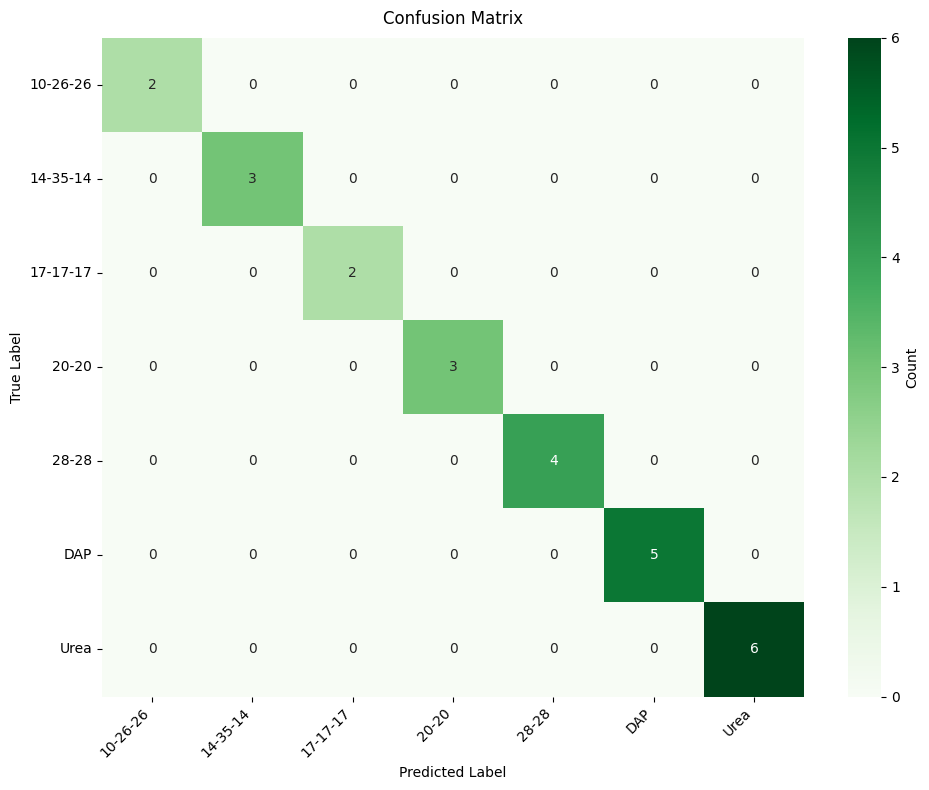

In [9]:
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=12, pad=10)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Feature Importance

         Feature  Importance
        Nitrogen    0.388290
       Potassium    0.327749
     Phosphorous    0.281424
        Moisture    0.002536
     Temparature    0.000000
Soil Type_Clayey    0.000000
 Soil Type_Loamy    0.000000
   Soil Type_Red    0.000000
 Soil Type_Sandy    0.000000
Crop Type_Cotton    0.000000


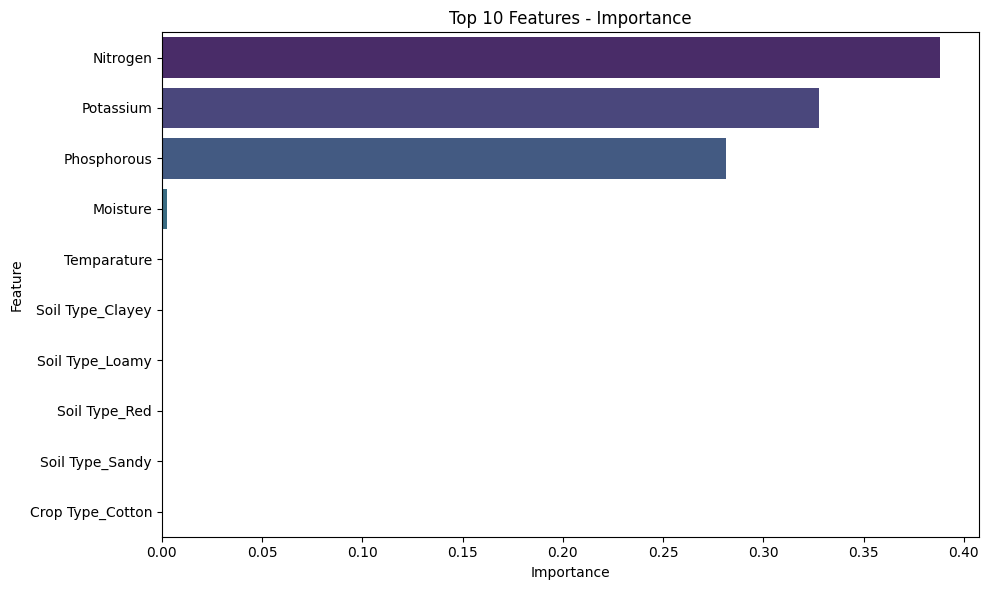

In [10]:
feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance.head(10).to_string(index=False))

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10),
           x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Features - Importance', fontsize=12)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Cross-Validation Visualization

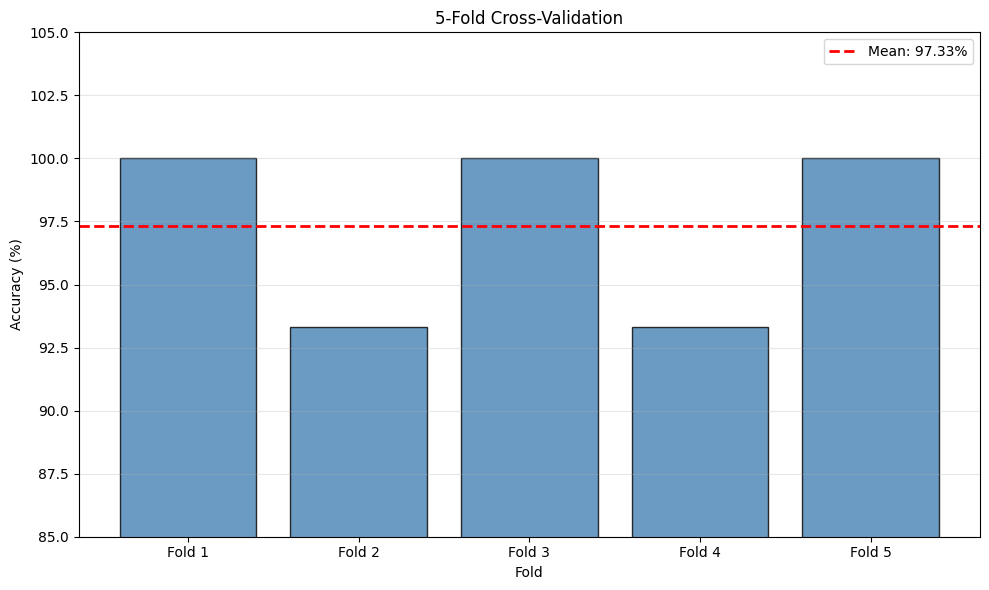

In [11]:
plt.figure(figsize=(10, 6))
folds = [f'Fold {i}' for i in range(1, 6)]
plt.bar(folds, cv_scores*100, color='steelblue', edgecolor='black', alpha=0.8)
plt.axhline(y=cv_scores.mean()*100, color='red', linestyle='--',
           linewidth=2, label=f'Mean: {cv_scores.mean()*100:.2f}%')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.title('5-Fold Cross-Validation', fontsize=12)
plt.ylim(85, 105)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Model saving

In [12]:
joblib.dump(model, 'fertilizer_recommendation_xgboost.pkl')
joblib.dump(scaler, 'fertilizer_scaler.pkl')
joblib.dump(label_encoder, 'fertilizer_encoder.pkl')

# Save columns information
columns_info = {
    'feature_columns': list(X_encoded.columns),
    'original_columns': list(X.columns),
    'classes': list(label_encoder.classes_)
}

with open('fertilizer_columns.json', 'w') as f:
    json.dump(columns_info, f, indent=4)

print("Saved files:")
print("  - fertilizer_recommendation_xgboost.pkl")
print("  - fertilizer_scaler.pkl")
print("  - fertilizer_encoder.pkl")
print("  - fertilizer_columns.json")

Saved files:
  - fertilizer_recommendation_xgboost.pkl
  - fertilizer_scaler.pkl
  - fertilizer_encoder.pkl
  - fertilizer_columns.json


# Summary

In [13]:
summary_data = {
    'Metric': [
        'Test Accuracy',
        'Train Accuracy',
        'F1-Score (Weighted)',
        'F1-Score (Macro)',
        'Precision',
        'Recall',
        'CV Mean',
        'CV Std'
    ],
    'Value': [
        f'{test_acc:.2f}%',
        f'{train_acc:.2f}%',
        f'{f1_weighted:.2f}%',
        f'{f1_macro:.2f}%',
        f'{precision:.2f}%',
        f'{recall:.2f}%',
        f'{cv_scores.mean()*100:.2f}%',
        f'{cv_scores.std()*100:.2f}%'
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\n" + "=" * 80)

# Model download
print("\nDownloading models...")
files.download('fertilizer_recommendation_xgboost.pkl')
files.download('fertilizer_scaler.pkl')
files.download('fertilizer_encoder.pkl')
files.download('fertilizer_columns.json')
print("Download completed")

             Metric   Value
      Test Accuracy 100.00%
     Train Accuracy 100.00%
F1-Score (Weighted) 100.00%
   F1-Score (Macro) 100.00%
          Precision 100.00%
             Recall 100.00%
            CV Mean  97.33%
             CV Std   3.27%




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download completed
